In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Global seed set to 0


# Loading Visium and scRNA-seq reference data

In [4]:
wk_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
data_root = os.path.join(wk_root, "result/cci/IDC/raw_data/")

adata_vis = sc.read_10x_h5(os.path.join(data_root, "V1_Human_Invasive_Ductal_Carcinoma_filtered_feature_bc_matrix.h5'))
adata_vis

/media/bgi/liukeyin/.conda/envs/cell2location_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 4727 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [2]:
results_folder = os.path.join(wk_root, 'result/cci/IDC/c2l_results/IDC_N_30_alpha_200_preprocessed/')

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [5]:
adata_vis.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

In [6]:
adata_vis.var

gene_ids    feature_types  genome
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38
FAM138A      ENSG00000237613  Gene Expression  GRCh38
OR4F5        ENSG00000186092  Gene Expression  GRCh38
AL627309.1   ENSG00000238009  Gene Expression  GRCh38
AL627309.3   ENSG00000239945  Gene Expression  GRCh38
...                      ...              ...     ...
AC141272.1   ENSG00000277836  Gene Expression  GRCh38
AC023491.2   ENSG00000278633  Gene Expression  GRCh38
AC007325.1   ENSG00000276017  Gene Expression  GRCh38
AC007325.4   ENSG00000278817  Gene Expression  GRCh38
AC007325.2   ENSG00000277196  Gene Expression  GRCh38

[36601 rows x 3 columns]

In [7]:
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.obs['sample'] = 'V1_Human_Invasive_Ductal_Carcinoma'

In [8]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]
adata_vis

View of AnnData object with n_obs × n_vars = 4727 × 36588
    obs: 'sample'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'MT_gene'
    obsm: 'MT'

In [9]:
pos_list = pd.read_csv(os.path.join(data_root,"tissue_positions_list.csv"),
                      header=None, index_col=0)
pos_list.columns=["in_tissue","array_row", "array_col", "pxl_col_in_fullres", "pxl_row_in_fullres"]
pos_list

in_tissue  array_row  array_col  pxl_col_in_fullres  \
0                                                                         
ACGCCTGACACGCGCT-1          0          0          0                3347   
TACCGATCCAACACTT-1          0          1          1                3584   
ATTAAAGCGGACGAGC-1          0          0          2                3346   
GATAAGGGACGATTAG-1          0          1          3                3582   
GTGCAAATCACCAATA-1          0          0          4                3344   
...                       ...        ...        ...                 ...   
GAACGTTTGTATCCAC-1          1         77        123               21531   
ATTGAATTCCCTGTAG-1          1         76        124               21293   
TACCTCACCAATTGTA-1          1         77        125               21530   
AGTCGAATTAGCGTAA-1          1         76        126               21292   
TTGAAGTGCATCTACA-1          1         77        127               21528   

                    pxl_row_in_fullres  
0                                       
ACGCCTGACACGCGCT-1               22253  
TACCGATCCAACACTT-1               22116  
ATTAAAGCGGACGAGC-1               21980  
GATAAGGGACGATTAG-1               21843  
GTGCAAATCACCAATA-1               21708  
...                                ...  
GAACGTTTGTATCCAC-1                5389  
ATTGAATTCCCTGTAG-1                5254  
TACCTCACCAATTGTA-1                5116  
AGTCGAATTAGCGTAA-1                4981  
TTGAAGTGCATCTACA-1                4843  

[4992 rows x 5 columns]

In [10]:
import cv2
id = 'V1_Human_Invasive_Ductal_Carcinoma'
hires_im = cv2.imread(os.path.join(data_root,"spatial/tissue_hires_image.png"))
adata_vis.uns["spatial"] = {id: {"images": {"hires": hires_im }}}

/media/bgi/liukeyin/.conda/envs/cell2location_env/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/media/bgi/liukeyin/.conda/envs/cell2location_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [11]:
import json
f = open(os.path.join(data_root,"scalefactors_json.json"))
scale_factor = json.load(f)
adata_vis.uns["spatial"][id]["scalefactors"] = scale_factor

In [12]:
adata_vis.obs = pd.concat([adata_vis.obs, pos_list], axis=1, join="inner")

In [13]:
adata_vis.var_names_make_unique()

In [14]:
adata_vis.obsm["spatial"] = pd.concat([adata_vis.obs["pxl_row_in_fullres"],adata_vis.obs["pxl_col_in_fullres"]], axis=1).to_numpy()

In [15]:
sc.pp.calculate_qc_metrics(adata_vis, qc_vars=["MT_gene"], inplace=True)

/media/bgi/liukeyin/.conda/envs/cell2location_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='n_genes_by_counts'>

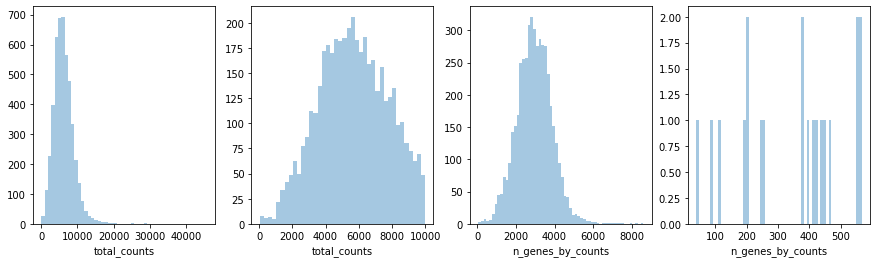

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata_vis.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata_vis.obs["total_counts"][adata_vis.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata_vis.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata_vis.obs["n_genes_by_counts"][adata_vis.obs["n_genes_by_counts"] < 600], kde=False, bins=60, ax=axs[3])

In [17]:
########  preprocessed by our method
# n_min_genes = adata_vis.obs["n_genes_by_counts"].quantile(q=0.05)
sc.pp.filter_cells(adata_vis, min_genes=5)
# sc.pp.filter_genes(adata, min_cells=5)
adata_vis

AnnData object with n_obs × n_vars = 4727 × 36588
    obs: 'sample', 'in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT_gene', 'log1p_total_counts_MT_gene', 'pct_counts_MT_gene', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'MT_gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'MT', 'spatial'

In [18]:
sc_data_folder = os.path.join(wk_root, "result/cci/IDC/anno_data/")

In [19]:
sc_meta = pd.read_csv(sc_data_folder + "Whole_miniatlas_meta.csv")
sc_meta

/tmp/ipykernel_25235/302862833.py:1: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.


NAME  Patient Percent_mito nCount_RNA  \
0                           TYPE    group      numeric    numeric   
1       CID3586_AAGACCTCAGCATGAG  CID3586  1.506221349       4581   
2       CID3586_AAGGTTCGTAGTACCT  CID3586  5.793742758       1726   
3       CID3586_ACCAGTAGTTGTGGCC  CID3586  1.383238405       1229   
4       CID3586_ACCCACTAGATGTCGG  CID3586  1.923076923       1352   
...                          ...      ...          ...        ...   
100060  CID4398_TCAGGTAGTACTCAAC  CID4398     2.698336       6189   
100061  CID4398_TCTATTGTCGCCATAA  CID4398     3.057905       4611   
100062  CID4398_TCTTTCCCAGTAAGCG  CID4398     3.682625       2987   
100063  CID4398_TGCCCATGTTACGGAG  CID4398     2.208325       5117   
100064  CID4398_TTGAACGTCCTATTCA  CID4398     2.126067       6679   

       nFeature_RNA celltype_major     celltype_minor      celltype_subset  \
0           numeric          group              group                group   
1              1689    Endothelial  Endothelial ACKR1    Endothelial ACKR1   
2               779    Endothelial  Endothelial ACKR1    Endothelial ACKR1   
3               514    Endothelial  Endothelial ACKR1    Endothelial ACKR1   
4               609    Endothelial  Endothelial ACKR1    Endothelial ACKR1   
...             ...            ...                ...                  ...   
100060         1251        Myeloid                DCs  Myeloid_c0_DC_LAMP3   
100061          719        Myeloid                DCs  Myeloid_c0_DC_LAMP3   
100062          887        Myeloid                DCs  Myeloid_c0_DC_LAMP3   
100063          870        Myeloid                DCs  Myeloid_c0_DC_LAMP3   
100064         1231        Myeloid                DCs  Myeloid_c0_DC_LAMP3   

       subtype     gene_module            Calls  normal_cell_call  \
0        group           group            group             group   
1        HER2+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
2        HER2+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
3        HER2+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
4        HER2+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
...        ...             ...              ...               ...   
100060     ER+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
100061     ER+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
100062     ER+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
100063     ER+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
100064     ER+  no_gene_module  no_scTYPER_call  no_inferCNV_call   

           CNA_value  
0              group  
1       no_CNA_value  
2       no_CNA_value  
3       no_CNA_value  
4       no_CNA_value  
...              ...  
100060  no_CNA_value  
100061  no_CNA_value  
100062  no_CNA_value  
100063  no_CNA_value  
100064  no_CNA_value  

[100065 rows x 13 columns]

In [20]:
sc_meta = sc_meta.drop(sc_meta.index[0])
sc_meta

NAME  Patient Percent_mito nCount_RNA  \
1       CID3586_AAGACCTCAGCATGAG  CID3586  1.506221349       4581   
2       CID3586_AAGGTTCGTAGTACCT  CID3586  5.793742758       1726   
3       CID3586_ACCAGTAGTTGTGGCC  CID3586  1.383238405       1229   
4       CID3586_ACCCACTAGATGTCGG  CID3586  1.923076923       1352   
5       CID3586_ACTGATGGTCAACTGT  CID3586  13.32554062       1711   
...                          ...      ...          ...        ...   
100060  CID4398_TCAGGTAGTACTCAAC  CID4398     2.698336       6189   
100061  CID4398_TCTATTGTCGCCATAA  CID4398     3.057905       4611   
100062  CID4398_TCTTTCCCAGTAAGCG  CID4398     3.682625       2987   
100063  CID4398_TGCCCATGTTACGGAG  CID4398     2.208325       5117   
100064  CID4398_TTGAACGTCCTATTCA  CID4398     2.126067       6679   

       nFeature_RNA celltype_major     celltype_minor      celltype_subset  \
1              1689    Endothelial  Endothelial ACKR1    Endothelial ACKR1   
2               779    Endothelial  Endothelial ACKR1    Endothelial ACKR1   
3               514    Endothelial  Endothelial ACKR1    Endothelial ACKR1   
4               609    Endothelial  Endothelial ACKR1    Endothelial ACKR1   
5               807    Endothelial  Endothelial ACKR1    Endothelial ACKR1   
...             ...            ...                ...                  ...   
100060         1251        Myeloid                DCs  Myeloid_c0_DC_LAMP3   
100061          719        Myeloid                DCs  Myeloid_c0_DC_LAMP3   
100062          887        Myeloid                DCs  Myeloid_c0_DC_LAMP3   
100063          870        Myeloid                DCs  Myeloid_c0_DC_LAMP3   
100064         1231        Myeloid                DCs  Myeloid_c0_DC_LAMP3   

       subtype     gene_module            Calls  normal_cell_call  \
1        HER2+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
2        HER2+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
3        HER2+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
4        HER2+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
5        HER2+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
...        ...             ...              ...               ...   
100060     ER+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
100061     ER+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
100062     ER+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
100063     ER+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
100064     ER+  no_gene_module  no_scTYPER_call  no_inferCNV_call   

           CNA_value  
1       no_CNA_value  
2       no_CNA_value  
3       no_CNA_value  
4       no_CNA_value  
5       no_CNA_value  
...              ...  
100060  no_CNA_value  
100061  no_CNA_value  
100062  no_CNA_value  
100063  no_CNA_value  
100064  no_CNA_value  

[100064 rows x 13 columns]

In [21]:
set(sc_meta['subtype'])

{'ER+', 'HER2+', 'TNBC'}

In [22]:
set(sc_meta['celltype_major'])

{'B-cells',
 'CAFs',
 'Cancer Epithelial',
 'Endothelial',
 'Myeloid',
 'Normal Epithelial',
 'PVL',
 'Plasmablasts',
 'T-cells'}

In [23]:
set(sc_meta['celltype_minor'])

{'B cells Memory',
 'B cells Naive',
 'CAFs MSC iCAF-like',
 'CAFs myCAF-like',
 'Cancer Basal SC',
 'Cancer Cycling',
 'Cancer Her2 SC',
 'Cancer LumA SC',
 'Cancer LumB SC',
 'Cycling PVL',
 'Cycling T-cells',
 'Cycling_Myeloid',
 'DCs',
 'Endothelial ACKR1',
 'Endothelial CXCL12',
 'Endothelial Lymphatic LYVE1',
 'Endothelial RGS5',
 'Luminal Progenitors',
 'Macrophage',
 'Mature Luminal',
 'Monocyte',
 'Myoepithelial',
 'NK cells',
 'NKT cells',
 'PVL Differentiated',
 'PVL Immature',
 'Plasmablasts',
 'T cells CD4+',
 'T cells CD8+'}

In [24]:
sc_meta = sc_meta[sc_meta['subtype']!='TNBC']
sc_meta

NAME  Patient Percent_mito nCount_RNA  \
1       CID3586_AAGACCTCAGCATGAG  CID3586  1.506221349       4581   
2       CID3586_AAGGTTCGTAGTACCT  CID3586  5.793742758       1726   
3       CID3586_ACCAGTAGTTGTGGCC  CID3586  1.383238405       1229   
4       CID3586_ACCCACTAGATGTCGG  CID3586  1.923076923       1352   
5       CID3586_ACTGATGGTCAACTGT  CID3586  13.32554062       1711   
...                          ...      ...          ...        ...   
100060  CID4398_TCAGGTAGTACTCAAC  CID4398     2.698336       6189   
100061  CID4398_TCTATTGTCGCCATAA  CID4398     3.057905       4611   
100062  CID4398_TCTTTCCCAGTAAGCG  CID4398     3.682625       2987   
100063  CID4398_TGCCCATGTTACGGAG  CID4398     2.208325       5117   
100064  CID4398_TTGAACGTCCTATTCA  CID4398     2.126067       6679   

       nFeature_RNA celltype_major     celltype_minor      celltype_subset  \
1              1689    Endothelial  Endothelial ACKR1    Endothelial ACKR1   
2               779    Endothelial  Endothelial ACKR1    Endothelial ACKR1   
3               514    Endothelial  Endothelial ACKR1    Endothelial ACKR1   
4               609    Endothelial  Endothelial ACKR1    Endothelial ACKR1   
5               807    Endothelial  Endothelial ACKR1    Endothelial ACKR1   
...             ...            ...                ...                  ...   
100060         1251        Myeloid                DCs  Myeloid_c0_DC_LAMP3   
100061          719        Myeloid                DCs  Myeloid_c0_DC_LAMP3   
100062          887        Myeloid                DCs  Myeloid_c0_DC_LAMP3   
100063          870        Myeloid                DCs  Myeloid_c0_DC_LAMP3   
100064         1231        Myeloid                DCs  Myeloid_c0_DC_LAMP3   

       subtype     gene_module            Calls  normal_cell_call  \
1        HER2+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
2        HER2+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
3        HER2+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
4        HER2+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
5        HER2+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
...        ...             ...              ...               ...   
100060     ER+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
100061     ER+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
100062     ER+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
100063     ER+  no_gene_module  no_scTYPER_call  no_inferCNV_call   
100064     ER+  no_gene_module  no_scTYPER_call  no_inferCNV_call   

           CNA_value  
1       no_CNA_value  
2       no_CNA_value  
3       no_CNA_value  
4       no_CNA_value  
5       no_CNA_value  
...              ...  
100060  no_CNA_value  
100061  no_CNA_value  
100062  no_CNA_value  
100063  no_CNA_value  
100064  no_CNA_value  

[57552 rows x 13 columns]

In [25]:
set(sc_meta['subtype'])

{'ER+', 'HER2+'}

In [26]:
set(sc_meta['celltype_major'])

{'B-cells',
 'CAFs',
 'Cancer Epithelial',
 'Endothelial',
 'Myeloid',
 'Normal Epithelial',
 'PVL',
 'Plasmablasts',
 'T-cells'}

In [27]:
set(sc_meta['celltype_minor'])

{'B cells Memory',
 'B cells Naive',
 'CAFs MSC iCAF-like',
 'CAFs myCAF-like',
 'Cancer Basal SC',
 'Cancer Cycling',
 'Cancer Her2 SC',
 'Cancer LumA SC',
 'Cancer LumB SC',
 'Cycling PVL',
 'Cycling T-cells',
 'Cycling_Myeloid',
 'DCs',
 'Endothelial ACKR1',
 'Endothelial CXCL12',
 'Endothelial Lymphatic LYVE1',
 'Endothelial RGS5',
 'Luminal Progenitors',
 'Macrophage',
 'Mature Luminal',
 'Monocyte',
 'Myoepithelial',
 'NK cells',
 'NKT cells',
 'PVL Differentiated',
 'PVL Immature',
 'Plasmablasts',
 'T cells CD4+',
 'T cells CD8+'}

In [28]:
sc_meta.index = sc_meta['NAME']
sc_meta.index.name = None
sc_meta

NAME  Patient Percent_mito  \
CID3586_AAGACCTCAGCATGAG  CID3586_AAGACCTCAGCATGAG  CID3586  1.506221349   
CID3586_AAGGTTCGTAGTACCT  CID3586_AAGGTTCGTAGTACCT  CID3586  5.793742758   
CID3586_ACCAGTAGTTGTGGCC  CID3586_ACCAGTAGTTGTGGCC  CID3586  1.383238405   
CID3586_ACCCACTAGATGTCGG  CID3586_ACCCACTAGATGTCGG  CID3586  1.923076923   
CID3586_ACTGATGGTCAACTGT  CID3586_ACTGATGGTCAACTGT  CID3586  13.32554062   
...                                            ...      ...          ...   
CID4398_TCAGGTAGTACTCAAC  CID4398_TCAGGTAGTACTCAAC  CID4398     2.698336   
CID4398_TCTATTGTCGCCATAA  CID4398_TCTATTGTCGCCATAA  CID4398     3.057905   
CID4398_TCTTTCCCAGTAAGCG  CID4398_TCTTTCCCAGTAAGCG  CID4398     3.682625   
CID4398_TGCCCATGTTACGGAG  CID4398_TGCCCATGTTACGGAG  CID4398     2.208325   
CID4398_TTGAACGTCCTATTCA  CID4398_TTGAACGTCCTATTCA  CID4398     2.126067   

                         nCount_RNA nFeature_RNA celltype_major  \
CID3586_AAGACCTCAGCATGAG       4581         1689    Endothelial   
CID3586_AAGGTTCGTAGTACCT       1726          779    Endothelial   
CID3586_ACCAGTAGTTGTGGCC       1229          514    Endothelial   
CID3586_ACCCACTAGATGTCGG       1352          609    Endothelial   
CID3586_ACTGATGGTCAACTGT       1711          807    Endothelial   
...                             ...          ...            ...   
CID4398_TCAGGTAGTACTCAAC       6189         1251        Myeloid   
CID4398_TCTATTGTCGCCATAA       4611          719        Myeloid   
CID4398_TCTTTCCCAGTAAGCG       2987          887        Myeloid   
CID4398_TGCCCATGTTACGGAG       5117          870        Myeloid   
CID4398_TTGAACGTCCTATTCA       6679         1231        Myeloid   

                             celltype_minor      celltype_subset subtype  \
CID3586_AAGACCTCAGCATGAG  Endothelial ACKR1    Endothelial ACKR1   HER2+   
CID3586_AAGGTTCGTAGTACCT  Endothelial ACKR1    Endothelial ACKR1   HER2+   
CID3586_ACCAGTAGTTGTGGCC  Endothelial ACKR1    Endothelial ACKR1   HER2+   
CID3586_ACCCACTAGATGTCGG  Endothelial ACKR1    Endothelial ACKR1   HER2+   
CID3586_ACTGATGGTCAACTGT  Endothelial ACKR1    Endothelial ACKR1   HER2+   
...                                     ...                  ...     ...   
CID4398_TCAGGTAGTACTCAAC                DCs  Myeloid_c0_DC_LAMP3     ER+   
CID4398_TCTATTGTCGCCATAA                DCs  Myeloid_c0_DC_LAMP3     ER+   
CID4398_TCTTTCCCAGTAAGCG                DCs  Myeloid_c0_DC_LAMP3     ER+   
CID4398_TGCCCATGTTACGGAG                DCs  Myeloid_c0_DC_LAMP3     ER+   
CID4398_TTGAACGTCCTATTCA                DCs  Myeloid_c0_DC_LAMP3     ER+   

                             gene_module            Calls  normal_cell_call  \
CID3586_AAGACCTCAGCATGAG  no_gene_module  no_scTYPER_call  no_inferCNV_call   
CID3586_AAGGTTCGTAGTACCT  no_gene_module  no_scTYPER_call  no_inferCNV_call   
CID3586_ACCAGTAGTTGTGGCC  no_gene_module  no_scTYPER_call  no_inferCNV_call   
CID3586_ACCCACTAGATGTCGG  no_gene_module  no_scTYPER_call  no_inferCNV_call   
CID3586_ACTGATGGTCAACTGT  no_gene_module  no_scTYPER_call  no_inferCNV_call   
...                                  ...              ...               ...   
CID4398_TCAGGTAGTACTCAAC  no_gene_module  no_scTYPER_call  no_inferCNV_call   
CID4398_TCTATTGTCGCCATAA  no_gene_module  no_scTYPER_call  no_inferCNV_call   
CID4398_TCTTTCCCAGTAAGCG  no_gene_module  no_scTYPER_call  no_inferCNV_call   
CID4398_TGCCCATGTTACGGAG  no_gene_module  no_scTYPER_call  no_inferCNV_call   
CID4398_TTGAACGTCCTATTCA  no_gene_module  no_scTYPER_call  no_inferCNV_call   

                             CNA_value  
CID3586_AAGACCTCAGCATGAG  no_CNA_value  
CID3586_AAGGTTCGTAGTACCT  no_CNA_value  
CID3586_ACCAGTAGTTGTGGCC  no_CNA_value  
CID3586_ACCCACTAGATGTCGG  no_CNA_value  
CID3586_ACTGATGGTCAACTGT  no_CNA_value  
...                                ...  
CID4398_TCAGGTAGTACTCAAC  no_CNA_value  
CID4398_TCTATTGTCGCCATAA  no_CNA_value  
CID4398_TCTTTCCCAGTAAGCG  no_CNA_value  
CID4398_TGCCCATGTTACGGAG  no_CNA_value  
CID4398_TTGAACG

In [29]:
set(sc_meta['celltype_subset'])

{'B cells Memory',
 'B cells Naive',
 'CAFs MSC iCAF-like s1',
 'CAFs MSC iCAF-like s2',
 'CAFs Transitioning s3',
 'CAFs myCAF like s4',
 'CAFs myCAF like s5',
 'Cancer Basal SC',
 'Cancer Cycling',
 'Cancer Her2 SC',
 'Cancer LumA SC',
 'Cancer LumB SC',
 'Cycling PVL',
 'Cycling_Myeloid',
 'Endothelial ACKR1',
 'Endothelial CXCL12',
 'Endothelial Lymphatic LYVE1',
 'Endothelial RGS5',
 'Luminal Progenitors',
 'Mature Luminal',
 'Myeloid_c0_DC_LAMP3',
 'Myeloid_c10_Macrophage_1_EGR1',
 'Myeloid_c11_cDC2_CD1C',
 'Myeloid_c12_Monocyte_1_IL1B',
 'Myeloid_c1_LAM1_FABP5',
 'Myeloid_c2_LAM2_APOE',
 'Myeloid_c3_cDC1_CLEC9A',
 'Myeloid_c4_DCs_pDC_IRF7',
 'Myeloid_c7_Monocyte_3_FCGR3A',
 'Myeloid_c8_Monocyte_2_S100A9',
 'Myeloid_c9_Macrophage_2_CXCL10',
 'Myoepithelial',
 'PVL Differentiated s3',
 'PVL Immature s1',
 'PVL_Immature s2',
 'Plasmablasts',
 'T_cells_c0_CD4+_CCR7',
 'T_cells_c10_NKT_cells_FCGR3A',
 'T_cells_c11_MKI67',
 'T_cells_c1_CD4+_IL7R',
 'T_cells_c2_CD4+_T-regs_FOXP3',
 'T_

In [30]:
adata_ref = sc.read_mtx(os.path.join(wk_root, 'result/cci/IDC/anno_data/matrix.mtx'), dtype='int32')
adata_ref = adata_ref.T.copy()

In [31]:
adata_ref

AnnData object with n_obs × n_vars = 100064 × 29733

In [32]:
adata_ref.X

<100064x29733 sparse matrix of type '<class 'numpy.int32'>'
	with 177994136 stored elements in Compressed Sparse Row format>

In [33]:
features = pd.read_csv(os.path.join(wk_root, 'result/cci/IDC/anno_data/features.tsv'), sep='\t', header=None)
features.columns = ['SYMBOL','SYMBOL_1','feature_types']
features

SYMBOL       SYMBOL_1    feature_types
0       RP11-34P13.7   RP11-34P13.7  Gene Expression
1         FO538757.3     FO538757.3  Gene Expression
2         FO538757.2     FO538757.2  Gene Expression
3         AP006222.2     AP006222.2  Gene Expression
4      RP4-669L17.10  RP4-669L17.10  Gene Expression
...              ...            ...              ...
29728   RP11-983C2.3   RP11-983C2.3  Gene Expression
29729      LINC00919      LINC00919  Gene Expression
29730  RP11-589P10.7  RP11-589P10.7  Gene Expression
29731       KRTAP9-2       KRTAP9-2  Gene Expression
29732    IGLVIV-66-1    IGLVIV-66-1  Gene Expression

[29733 rows x 3 columns]

In [34]:
barcodes = pd.read_csv(os.path.join(wk_root, 'result/cci/IDC/anno_data/barcodes.tsv'), sep='\t', header=None)
barcodes.columns = ['barcodes']
barcodes

barcodes
0       CID3586_AAGACCTCAGCATGAG
1       CID3586_AAGGTTCGTAGTACCT
2       CID3586_ACCAGTAGTTGTGGCC
3       CID3586_ACCCACTAGATGTCGG
4       CID3586_ACTGATGGTCAACTGT
...                          ...
100059  CID4398_TCAGGTAGTACTCAAC
100060  CID4398_TCTATTGTCGCCATAA
100061  CID4398_TCTTTCCCAGTAAGCG
100062  CID4398_TGCCCATGTTACGGAG
100063  CID4398_TTGAACGTCCTATTCA

[100064 rows x 1 columns]

In [35]:
adata_ref.obs_names = barcodes['barcodes']
adata_ref.var_names = features['SYMBOL']
adata_ref.obs_names.name = None
adata_ref.var_names.name = None

In [36]:
adata_ref

AnnData object with n_obs × n_vars = 100064 × 29733

In [37]:
sc_meta['NAME'].values

array(['CID3586_AAGACCTCAGCATGAG', 'CID3586_AAGGTTCGTAGTACCT',
       'CID3586_ACCAGTAGTTGTGGCC', ..., 'CID4398_TCTTTCCCAGTAAGCG',
       'CID4398_TGCCCATGTTACGGAG', 'CID4398_TTGAACGTCCTATTCA'],
      dtype=object)

In [38]:
adata_ref = adata_ref[sc_meta['NAME'].values, :].copy()
adata_ref

AnnData object with n_obs × n_vars = 57552 × 29733

In [39]:
adata_ref.obs['Annotation'] = sc_meta['celltype_minor']

In [40]:
adata_ref.obs

Annotation
CID3586_AAGACCTCAGCATGAG  Endothelial ACKR1
CID3586_AAGGTTCGTAGTACCT  Endothelial ACKR1
CID3586_ACCAGTAGTTGTGGCC  Endothelial ACKR1
CID3586_ACCCACTAGATGTCGG  Endothelial ACKR1
CID3586_ACTGATGGTCAACTGT  Endothelial ACKR1
...                                     ...
CID4398_TCAGGTAGTACTCAAC                DCs
CID4398_TCTATTGTCGCCATAA                DCs
CID4398_TCTTTCCCAGTAAGCG                DCs
CID4398_TGCCCATGTTACGGAG                DCs
CID4398_TTGAACGTCCTATTCA                DCs

[57552 rows x 1 columns]

In [41]:
adata_ref.var['SYMBOL'] = adata_ref.var.index

In [42]:
adata_ref.var_names_make_unique()

In [43]:
adata_ref.var

SYMBOL
RP11-34P13.7    RP11-34P13.7
FO538757.3        FO538757.3
FO538757.2        FO538757.2
AP006222.2        AP006222.2
RP4-669L17.10  RP4-669L17.10
...                      ...
RP11-983C2.3    RP11-983C2.3
LINC00919          LINC00919
RP11-589P10.7  RP11-589P10.7
KRTAP9-2            KRTAP9-2
IGLVIV-66-1      IGLVIV-66-1

[29733 rows x 1 columns]

In [44]:
adata_ref.obs['Sample'] = sc_meta['Patient']

In [53]:
# sc.pp.calculate_qc_metrics(adata_ref, inplace=True)

/media/bgi/liukeyin/.conda/envs/cell2location_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='n_cells_by_counts'>

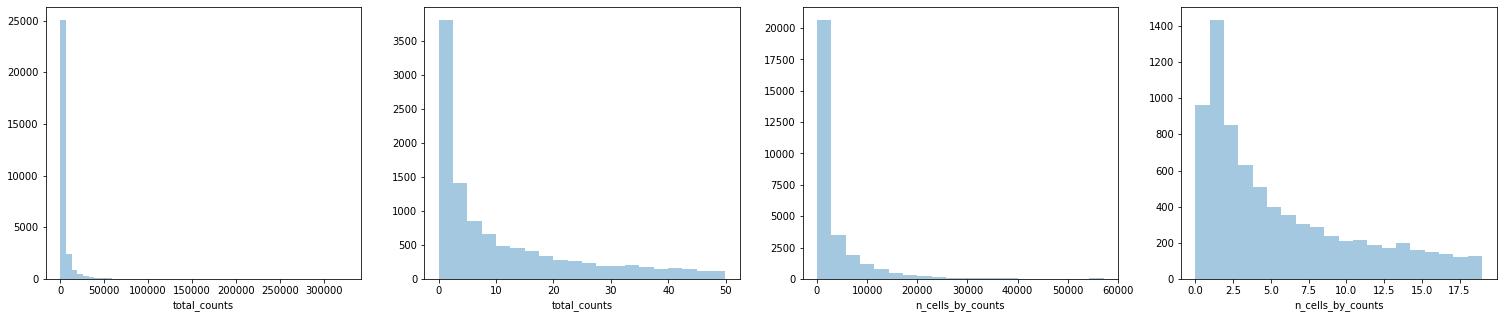

In [54]:
# fig, axs = plt.subplots(1, 4, figsize=(26, 5))
# sns.distplot(adata_ref.var["total_counts"], kde=False, ax=axs[0])
# sns.distplot(adata_ref.var["total_counts"][adata_ref.var["total_counts"] < 50], kde=False, bins=20, ax=axs[1])
# sns.distplot(adata_ref.var["n_cells_by_counts"], kde=False, bins=20, ax=axs[2])
# sns.distplot(adata_ref.var["n_cells_by_counts"][adata_ref.var["n_cells_by_counts"] < 20], kde=False, bins=20, ax=axs[3])

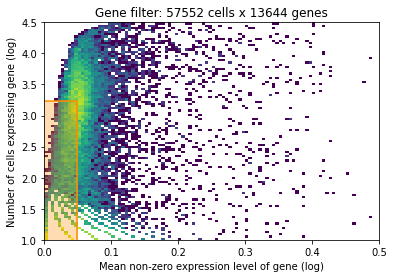

AnnData object with n_obs × n_vars = 57552 × 13644
    obs: 'Annotation', 'Sample'
    var: 'SYMBOL', 'n_cells', 'nonz_mean'

In [47]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
# selected = filter_genes(adata_ref, cell_count_cutoff=3, cell_percentage_cutoff2=0.05, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()
adata_ref

In [ ]:
# fig, axs = plt.subplots(1, 4, figsize=(26, 5))
# sns.distplot(adata_ref.var["total_counts"], kde=False, ax=axs[0])
# sns.distplot(adata_ref.var["total_counts"][adata_ref.var["total_counts"] < 50], kde=False, bins=10, ax=axs[1])
# sns.distplot(adata_ref.var["n_cells_by_counts"], kde=False, bins=10, ax=axs[2])
# sns.distplot(adata_ref.var["n_cells_by_counts"][adata_ref.var["n_cells_by_counts"] < 20], kde=False, bins=10, ax=axs[3])

In [49]:
adata_ref.var

SYMBOL  n_cells  nonz_mean
FO538757.2        FO538757.2     2383   1.159043
LINC00115          LINC00115      349   1.157593
FAM41C                FAM41C      128   1.140625
NOC2L                  NOC2L     3627   1.099531
KLHL17                KLHL17      203   1.142857
...                      ...      ...        ...
GAGE1                  GAGE1       42   1.523810
RP11-730G20.1  RP11-730G20.1        8   1.125000
CST9L                  CST9L       45   1.244444
RP11-5P18.5      RP11-5P18.5       11   1.181818
AC005008.2        AC005008.2        7   1.142857

[13644 rows x 3 columns]

# Estimation of reference cell type signatures (NB regression)

In [50]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='Sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='Annotation',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
#                         categorical_covariate_keys=['Method']
                       )

In [51]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample',
│   'labels_key': 'Annotation',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 57552 │
│          n_vars          │ 13644 │
│         n_batch          │  16   │
│         n_labels         │  29   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │  CID3586   │          0          │
│                     │  CID3838   │          1          │
│                     │  CID3921   │          2          │
│                     │  CID3941   │          3          │
│                     │  CID3948   │          4          │
│                     │  CID4040   │          5          │
│                     │  CID4066   │          6          │
│                     │  CID4067   │          7          │
│                     │  CID4290A  │          8          │
│                     │  CID4398   │          9          │
│                     │  CID4461   │         10          │
│                     │  CID4463   │         11          │
│                     │  CID4471   │         12          │
│                     │  CID45171  │         13          │
│                     │  CID4530N  │         14          │
│                     │  CID4535   │         15          │
└─────────────────────┴────────────┴─────────────────────┘

                             labels State Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃         Categories          ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Annotation'] │       B cells Memory        │          0          │
│                         │        B cells Naive        │          1          │
│                         │     CAFs MSC iCAF-like      │          2          │
│                         │       CAFs myCAF-like       │          3          │
│                         │       Cancer Basal SC       │          4          │
│                         │       Cancer Cycling        │          5          │
│                         │       Cancer Her2 SC        │          6          │
│                         │       Cancer LumA SC        │          7          │
│                         │       Cancer LumB SC        │          8          │
│                         │         Cycling PVL         │          9          │
│                         │       Cycling T-cells       │         10          │
│                         │       Cycling_Myeloid       │         11          │
│                         │             DCs             │         12          │
│                         │      Endothelial ACKR1      │         13          │
│                         │     Endothelial CXCL12      │         14          │
│                         │ Endothelial Lymphatic LYVE1 │         15          │
│                         │      Endothelial RGS5       │         16          │
│                         │     Luminal Progenitors     │         17          │
│                         │         Macrophage          │         18          │
│                         │       Mature Luminal        │         19          │
│                         │          Monocyte           │         20          │
│                         │        Myoepithelial        │         21          │
│                         │          NK cells           │         22          │
│                         │          NKT cells          │         23          │
│                         │     PVL Differentiated      │         24          │
│                         │        PVL Immature         │         25          │
│                         │        Plasmablasts         │         26          │
│                         │        T cells CD4+         │         27          │
│                         │        T cells CD8+         │         28          │
└─────────────────────────┴─────────────────────────────┴─────────────────────┘

In [52]:
adata_ref.obs['Annotation']

CID3586_AAGACCTCAGCATGAG    Endothelial ACKR1
CID3586_AAGGTTCGTAGTACCT    Endothelial ACKR1
CID3586_ACCAGTAGTTGTGGCC    Endothelial ACKR1
CID3586_ACCCACTAGATGTCGG    Endothelial ACKR1
CID3586_ACTGATGGTCAACTGT    Endothelial ACKR1
                                  ...        
CID4398_TCAGGTAGTACTCAAC                  DCs
CID4398_TCTATTGTCGCCATAA                  DCs
CID4398_TCTTTCCCAGTAAGCG                  DCs
CID4398_TGCCCATGTTACGGAG                  DCs
CID4398_TTGAACGTCCTATTCA                  DCs
Name: Annotation, Length: 57552, dtype: object

In [53]:
adata_ref.X

<57552x13644 sparse matrix of type '<class 'numpy.int32'>'
	with 89948223 stored elements in Compressed Sparse Row format>

In [54]:
adata_ref

AnnData object with n_obs × n_vars = 57552 × 13644
    obs: 'Annotation', 'Sample', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'SYMBOL', 'n_cells', 'nonz_mean'
    uns: '_scvi_uuid', '_scvi_manager_uuid'

In [55]:
adata_ref.var

SYMBOL  n_cells  nonz_mean
FO538757.2        FO538757.2     2383   1.159043
LINC00115          LINC00115      349   1.157593
FAM41C                FAM41C      128   1.140625
NOC2L                  NOC2L     3627   1.099531
KLHL17                KLHL17      203   1.142857
...                      ...      ...        ...
GAGE1                  GAGE1       42   1.523810
RP11-730G20.1  RP11-730G20.1        8   1.125000
CST9L                  CST9L       45   1.244444
RP11-5P18.5      RP11-5P18.5       11   1.181818
AC005008.2        AC005008.2        7   1.142857

[13644 rows x 3 columns]

In [56]:
mod.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)


# train(max_epochs: Optional[int] = None, batch_size: int = 2500, train_size: float = 1, lr: float = 0.002, **kwargs)

# max_epochs – Number of passes through the dataset. If None, defaults to np.min([round((20000 / n_cells) * 400), 400])
# train_size – Size of training set in the range [0.0, 1.0].
# batch_size – Minibatch size to use during training. If None, no minibatching occurs and all data is copied to device (e.g., GPU).
# lr – Optimiser learning rate (default optimiser is ClippedAdam). Specifying optimiser via plan_kwargs overrides this choice of lr.
# kwargs – Other arguments to scvi.model.base.PyroSviTrainMixin().train() method

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/media/bgi/liukeyin/.conda/envs/cell2location_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 250/250: 100%|███████████████████████████████████████████| 250/250 [24:54<00:00,  5.98s/it, v_num=1, elbo_train=1.52e+8]


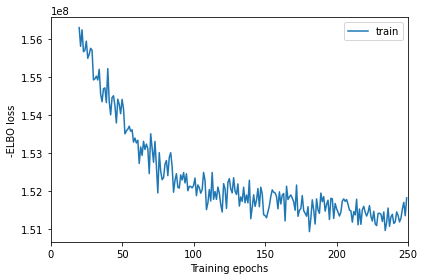

In [57]:
mod.plot_history(20)

In [58]:
adata_ref

AnnData object with n_obs × n_vars = 57552 × 13644
    obs: 'Annotation', 'Sample', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'SYMBOL', 'n_cells', 'nonz_mean'
    uns: '_scvi_uuid', '_scvi_manager_uuid'

In [59]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc_IDC.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|████████████████████████████████████████████████████| 999/999 [00:16<00:00, 62.14it/s]


'./c2l_results/IDC_N_30_alpha_200_preprocessed//reference_signatures/sc_mouse_brain.h5ad'

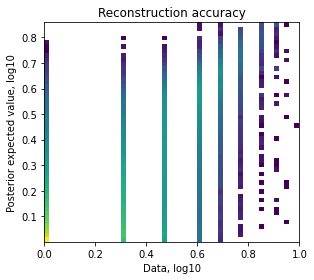

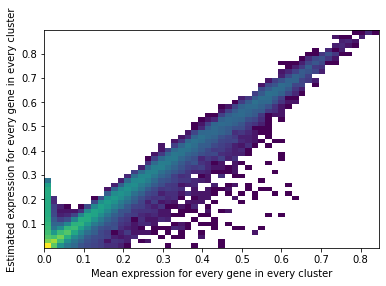

In [60]:
# Examine QC plots.

# Reconstruction accuracy to assess if there are any issues with inference. 
# This 2D histogram plot should have most observations along a noisy diagonal.

# The estimated expression signatures are distinct from mean expression in each cluster because of batch effects. 
# For scRNA-seq datasets which do not suffer from batch effect (this dataset does), 
# cluster average expression can be used instead of estimating signatures with a model. 
# When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, 
# density everywhere) it indicates problems with signature estimation.
mod.plot_QC()

In [28]:
## reload

# adata_file = f"{ref_run_name}/sc_mouse_brain.h5ad"
# adata_ref = sc.read_h5ad(adata_file)
# mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

In [61]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

B cells Memory  B cells Naive  CAFs MSC iCAF-like  \
FO538757.2        0.032390       0.058470            0.069272   
LINC00115         0.003377       0.212252            0.003696   
FAM41C            0.002019       0.457757            0.000872   
NOC2L             0.087671       0.178125            0.077034   
KLHL17            0.001897       0.386679            0.003967   

            CAFs myCAF-like  Cancer Basal SC  
FO538757.2         0.030311         0.037727  
LINC00115          0.001791         0.051111  
FAM41C             0.001166         0.065397  
NOC2L              0.041722         0.067128  
KLHL17             0.004034         0.048144

In [62]:
inf_aver.index = adata_ref.var['SYMBOL']

In [63]:
inf_aver

B cells Memory  B cells Naive  CAFs MSC iCAF-like  \
SYMBOL                                                             
FO538757.2           0.032390       0.058470            0.069272   
LINC00115            0.003377       0.212252            0.003696   
FAM41C               0.002019       0.457757            0.000872   
NOC2L                0.087671       0.178125            0.077034   
KLHL17               0.001897       0.386679            0.003967   
...                       ...            ...                 ...   
GAGE1                0.001076       0.068874            0.000702   
RP11-730G20.1        0.013956       0.620000            0.006669   
CST9L                0.001388       0.290305            0.000803   
RP11-5P18.5          0.001083       0.076653            0.000769   
AC005008.2           0.110011       0.573058            0.054410   

               CAFs myCAF-like  Cancer Basal SC  Cancer Cycling  \
SYMBOL                                                            
FO538757.2            0.030311         0.037727        0.023499   
LINC00115             0.001791         0.051111        0.005215   
FAM41C                0.001166         0.065397        0.002849   
NOC2L                 0.041722         0.067128        0.123262   
KLHL17                0.004034         0.048144        0.003187   
...                        ...              ...             ...   
GAGE1                 0.000674         0.012034        0.002187   
RP11-730G20.1         0.004644         0.323482        0.018091   
CST9L                 0.000683         0.040705        0.002223   
RP11-5P18.5           0.000683         0.015938        0.001593   
AC005008.2            0.058055         0.442273        0.121120   

               Cancer Her2 SC  Cancer LumA SC  Cancer LumB SC  Cycling PVL  \
SYMBOL                                                                       
FO538757.2           0.023461        0.015208        0.020176     0.085687   
LINC00115            0.002413        0.000937        0.001734     0.325669   
FAM41C               0.002217        0.000572        0.001070     0.564483   
NOC2L                0.166078        0.083692        0.092956     0.092769   
KLHL17               0.001558        0.000739        0.001286     0.433311   
...                       ...             ...             ...          ...   
GAGE1                0.000760        0.000275        0.001016     0.128897   
RP11-730G20.1        0.008254        0.000782        0.003274     0.693450   
CST9L                0.000840        0.000185        0.013901     0.491306   
RP11-5P18.5          0.001050        0.000839        0.000500     0.099834   
AC005008.2           0.078087        0.004679        0.027599     0.748987   

               ...  Mature Luminal  Monocyte  Myoepithelial  NK cells  \
SYMBOL         ...                                                      
FO538757.2     ...        0.036277  0.031769       0.061046  0.052380   
LINC00115      ...        0.003984  0.008421       0.005385  0.006788   
FAM41C         ...        0.002637  0.008145       0.001712  0.005458   
NOC2L          ...        0.100290  0.038259       0.112158  0.091509   
KLHL17         ...        0.004766  0.004134       0.002306  0.003284   
...            ...             ...       ...            ...       ...   
GAGE1          ...        0.001504  0.001906       0.001504  0.001322   
RP11-730G20.1  ...        0.009813  0.041222       0.014496  0.022268   
CST9L          ...        0.001517  0.002469       0.001745  0.001629   
RP11-5P18.5    ...        0.001698  0.001949       0.001614  0.001551   
AC005008.2     ...        0.142456  0.169095       0.125264  0.161929   

               NKT cells  PVL Differentiated  PVL Immature  Plasmablasts  \
SYMBOL                                                                     
FO538757.2      0.033086            0.050402      0.063998      0.003335   
LINC00115       0.013198            0.006945      0.005554      0

In [32]:
# adata_ref.varm

In [33]:
# adata_ref.varm['means_per_cluster_mu_fg']

In [34]:
# adata_ref.varm['stds_per_cluster_mu_fg']

In [35]:
# adata_ref.varm['q05_per_cluster_mu_fg']

In [36]:
# adata_ref.varm['q95_per_cluster_mu_fg']

In [37]:
# adata_ref.uns['mod']['factor_names']

# Cell2location: spatial mapping

In [64]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [65]:
adata_vis

AnnData object with n_obs × n_vars = 4727 × 11260
    obs: 'sample', 'in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT_gene', 'log1p_total_counts_MT_gene', 'pct_counts_MT_gene', 'n_genes', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'MT_gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'MT', 'spatial'

In [66]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=30,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=200
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 4727  │
│          n_vars          │ 11260 │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                               batch State Registry                               
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃             Categories             ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ V1_Human_Invasive_Ductal_Carcinoma │          0          │
└─────────────────────┴────────────────────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [67]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # 4096 ---- GPU Memory Usage: 5075MiB
          # 2048 ---- GPU Memory Usage: 3225MiB
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/media/bgi/liukeyin/.conda/envs/cell2location_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/media/bgi/liukeyin/.conda/envs/cell2location_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 30000/30000: 100%|███████████████| 30000/30000 [1:18:22<00:00,  6.38it/s, v_num=1, elbo_train=2.93e+7]


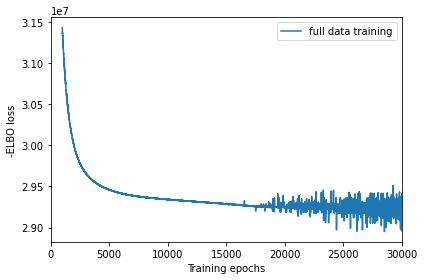

In [68]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training'])

In [69]:
# # In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
#     adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': 2048, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp_IDC.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████████████████████████████| 999/999 [00:27<00:00, 36.47it/s]


'./c2l_results/IDC_N_30_alpha_200_preprocessed//cell2location_map/sp_IDC.h5ad'

In [44]:
# #reload 

# adata_file = f"{run_name}/sp_mouse_brain.h5ad"
# adata_vis = sc.read_h5ad(adata_file)
# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

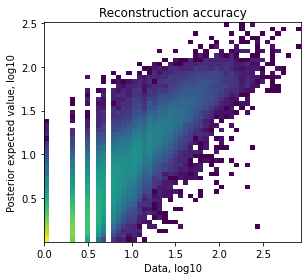

In [70]:
mod.plot_QC()

In [71]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

In [72]:
adata_vis

AnnData object with n_obs × n_vars = 4727 × 11260
    obs: 'sample', 'in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT_gene', 'log1p_total_counts_MT_gene', 'pct_counts_MT_gene', 'n_genes', '_indices', '_scvi_batch', '_scvi_labels', 'B cells Memory', 'B cells Naive', 'CAFs MSC iCAF-like', 'CAFs myCAF-like', 'Cancer Basal SC', 'Cancer Cycling', 'Cancer Her2 SC', 'Cancer LumA SC', 'Cancer LumB SC', 'Cycling PVL', 'Cycling T-cells', 'Cycling_Myeloid', 'DCs', 'Endothelial ACKR1', 'Endothelial CXCL12', 'Endothelial Lymphatic LYVE1', 'Endothelial RGS5', 'Luminal Progenitors', 'Macrophage', 'Mature Luminal', 'Monocyte', 'Myoepithelial', 'NK cells', 'NKT cells', 'PVL Differentiated', 'PVL Immature', 'Plasmablasts', 'T cells CD4+', 'T cells 

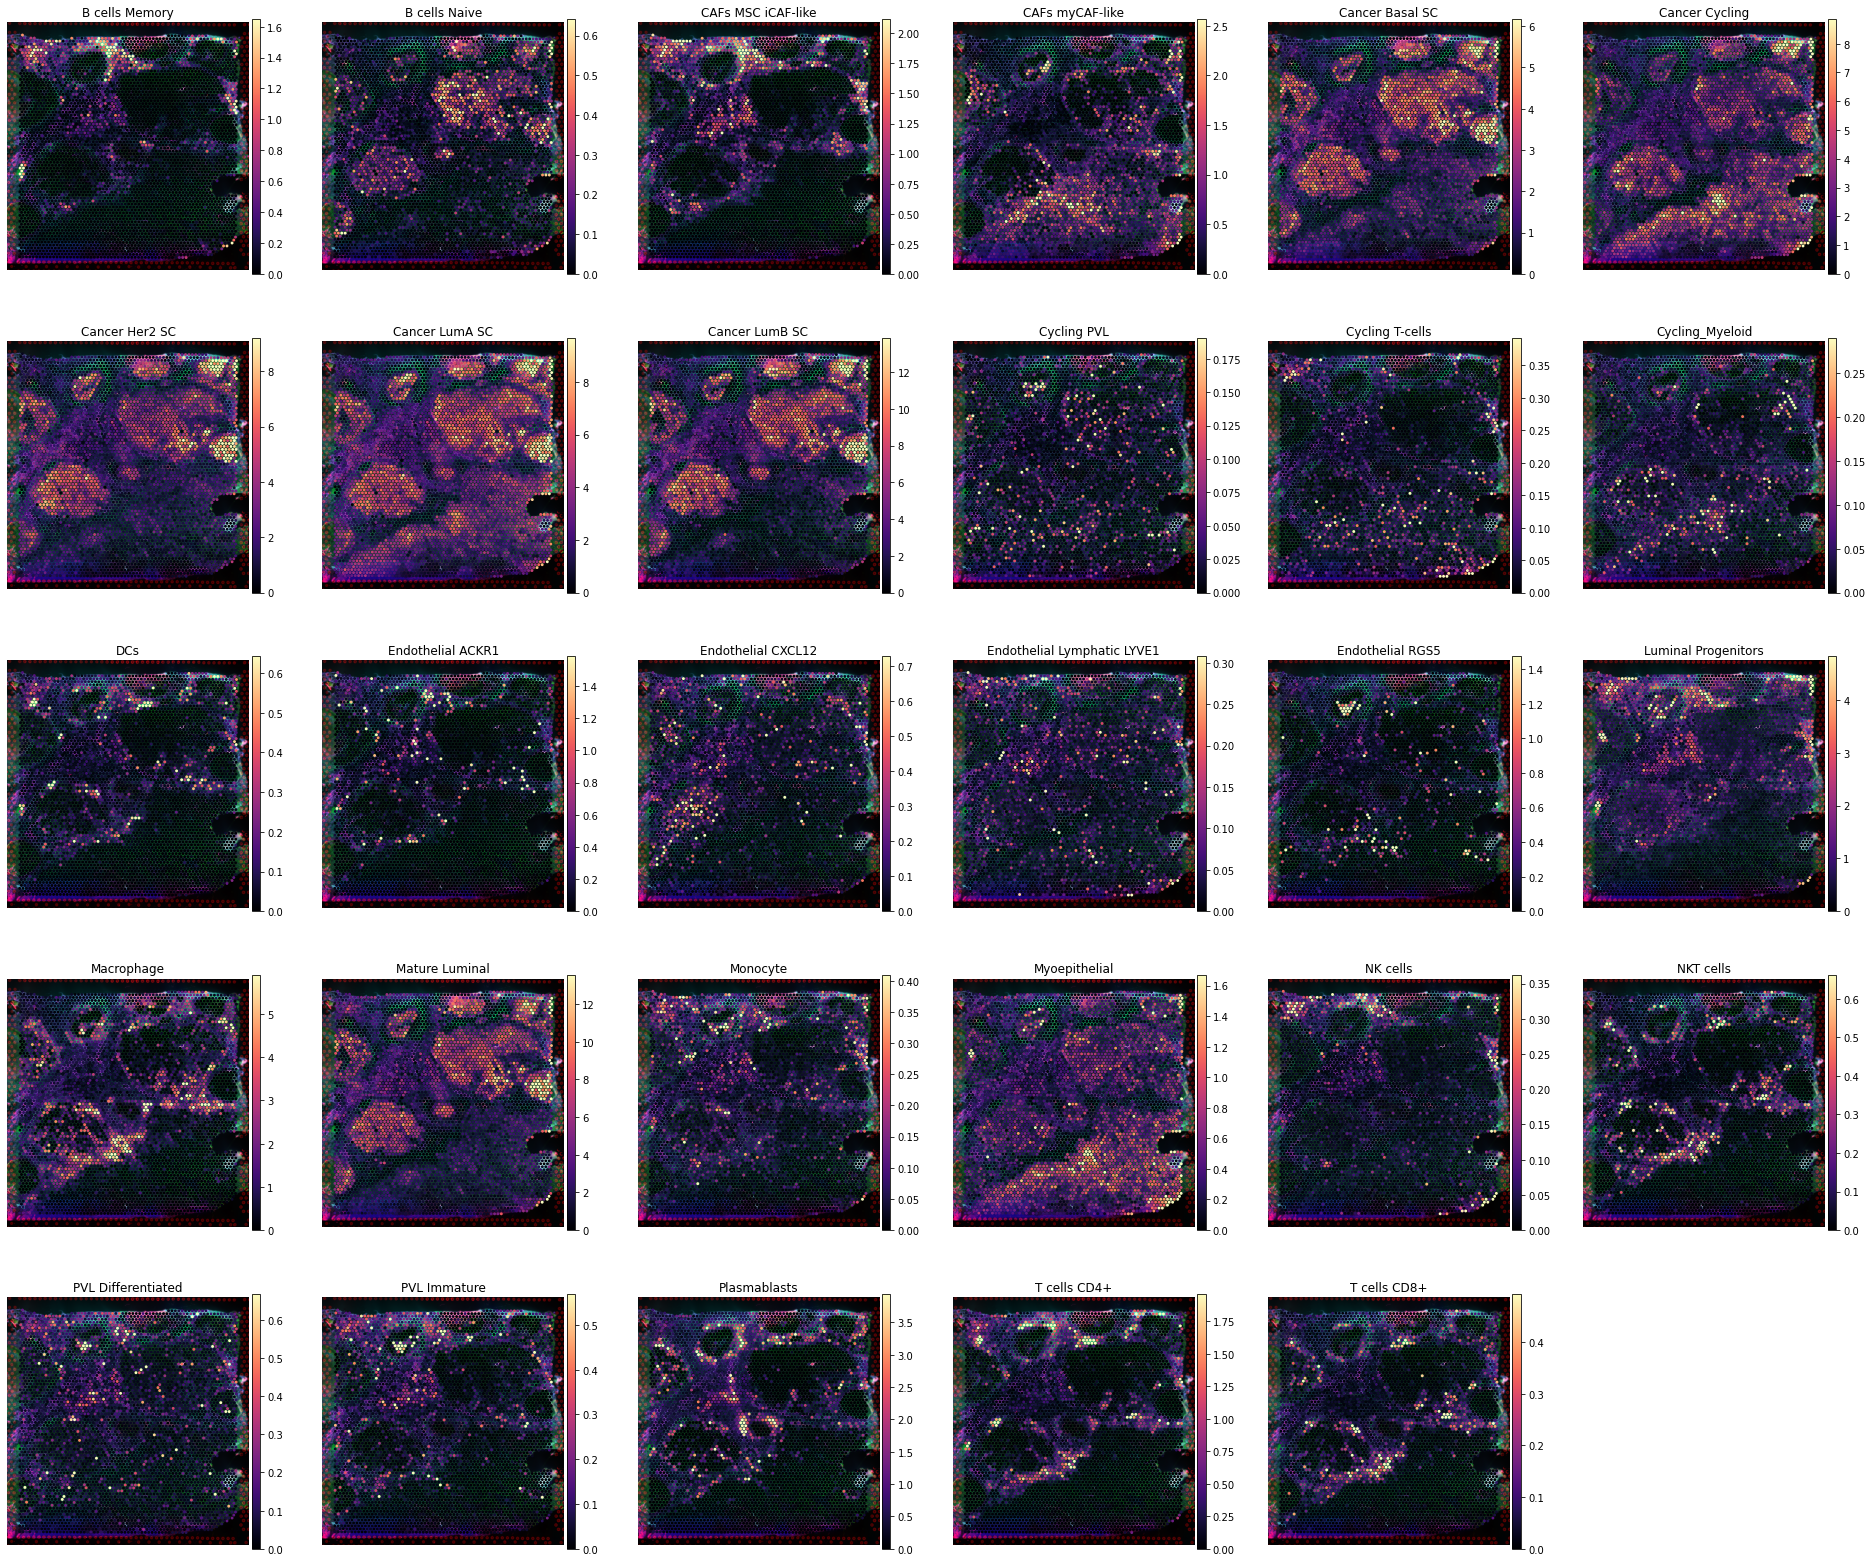

In [74]:
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(adata_vis, cmap='magma',
                  # show first 8 cell types
                  color=['B cells Memory', 'B cells Naive', 'CAFs MSC iCAF-like', 'CAFs myCAF-like',
                         'Cancer Basal SC', 'Cancer Cycling', 'Cancer Her2 SC', 'Cancer LumA SC',
                         'Cancer LumB SC', 'Cycling PVL', 'Cycling T-cells', 'Cycling_Myeloid',
                         'DCs', 'Endothelial ACKR1', 'Endothelial CXCL12', 'Endothelial Lymphatic LYVE1',
                         'Endothelial RGS5', 'Luminal Progenitors', 'Macrophage', 'Mature Luminal',
                         'Monocyte', 'Myoepithelial', 'NK cells', 'NKT cells', 'PVL Differentiated',
                         'PVL Immature', 'Plasmablasts', 'T cells CD4+', 'T cells CD8+'],
                  ncols=6, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2',
                  outline_color = 'white', frameon=False
                 )

In [75]:
adata_vis

AnnData object with n_obs × n_vars = 4727 × 11260
    obs: 'sample', 'in_tissue', 'array_row', 'array_col', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT_gene', 'log1p_total_counts_MT_gene', 'pct_counts_MT_gene', 'n_genes', '_indices', '_scvi_batch', '_scvi_labels', 'B cells Memory', 'B cells Naive', 'CAFs MSC iCAF-like', 'CAFs myCAF-like', 'Cancer Basal SC', 'Cancer Cycling', 'Cancer Her2 SC', 'Cancer LumA SC', 'Cancer LumB SC', 'Cycling PVL', 'Cycling T-cells', 'Cycling_Myeloid', 'DCs', 'Endothelial ACKR1', 'Endothelial CXCL12', 'Endothelial Lymphatic LYVE1', 'Endothelial RGS5', 'Luminal Progenitors', 'Macrophage', 'Mature Luminal', 'Monocyte', 'Myoepithelial', 'NK cells', 'NKT cells', 'PVL Differentiated', 'PVL Immature', 'Plasmablasts', 'T cells CD4+', 'T cells 

In [76]:
adata_vis.write('./c2l_results/IDC_N_30_alpha_200_preprocessed/adata_IDC_result.h5ad')